With meridional regions of impact identified in the lat_time_impact notebook, the purpose of this script is now to average over those latitude bands, and inspect the vertical structure of the impact in those regions. These are plotted alongside a thin reproduced version of the relevant latitude band extracted from the lat_time_impact figure

In [115]:
import sys
import pdb
import numpy as np
import xarray as xr
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from cftime import DatetimeNoLeap as date
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 14,   # Axis labels
    'xtick.labelsize' : 12,   # X-axis tick labels
    'ytick.labelsize' : 12,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil

In [128]:
# ----- define latitude bands
latbands = [[30, 50], [-5, 5], [-50, -30]]
nband     = len(latbands)

# ----- get U data on each band
udir = [putil.get_daily_variable('U', skip_nosrctag=True, latmin=b[0], latmax=b[1]) for b in latbands]
# ----- extract data at pressure levels
u        = [ud['ensmean'] for ud in udir]
u_cf     = [ud['cfmean'] for ud in udir]
u_impact = [ud['impact'] for ud in udir]
u_pval   = [ud['pval'] for ud in udir]
# ----- nan insignificant values
u_impact_filtered = [u_impact[i].where(u_pval[i] < 0.05) for i in range(nband)]
# ----- get dims
time, plev = [u[0].time, u[0].plev]
time = [datetime(t.year,t.month,t.day) for t in time.values]

# ----- now do the same for the non-zonally averaged data to reproduce the data from the lat_time_impact plot
#pp = [1, 10, 30] #pressure levels to extract (matches lat_time_impact plot)
pp = 10
udir = putil.get_daily_variable('U', skip_nosrctag=True)
up        = udir['ensmean'].sel(plev=pp, method='nearest')
up_cf     = udir['cfmean'].sel(plev=pp, method='nearest')
up_impact = udir['impact'].sel(plev=pp, method='nearest')
up_pval   = udir['pval'].sel(plev=pp, method='nearest')
up_impact_filtered = up_impact.where(up_pval < 0.05)#, other=0)
lat = up.lat

# ----- set limits
plim      = [0.3, 400]
timelim = [time[0], datetime(time[0].year+2,time[0].month,time[0].day)]

getting data for variable U...
getting data for variable U...
getting data for variable U...
getting data for variable U...


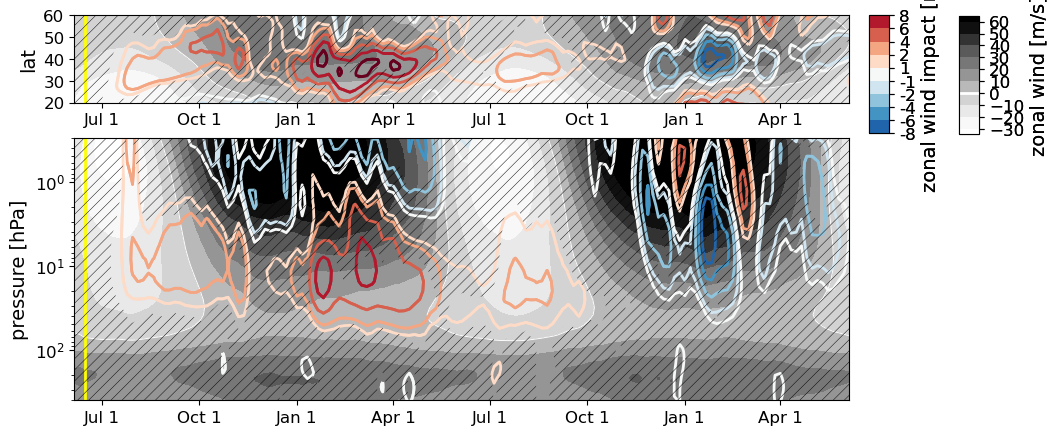

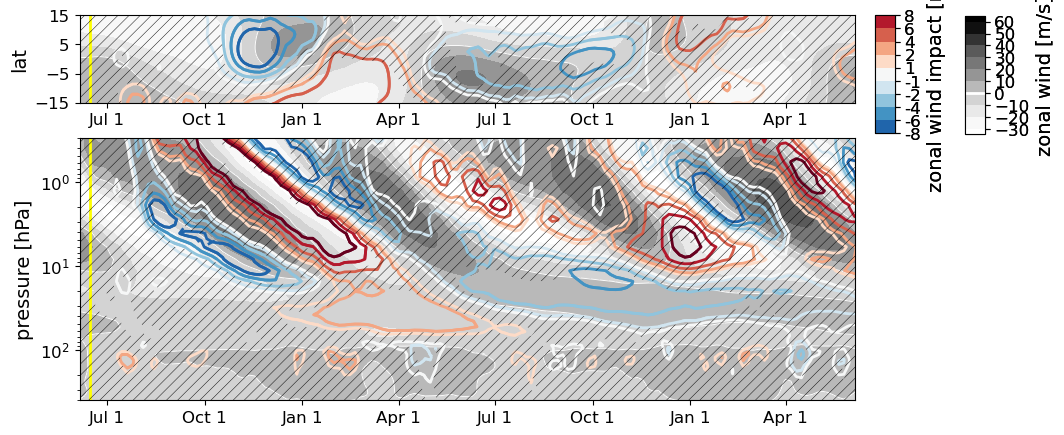

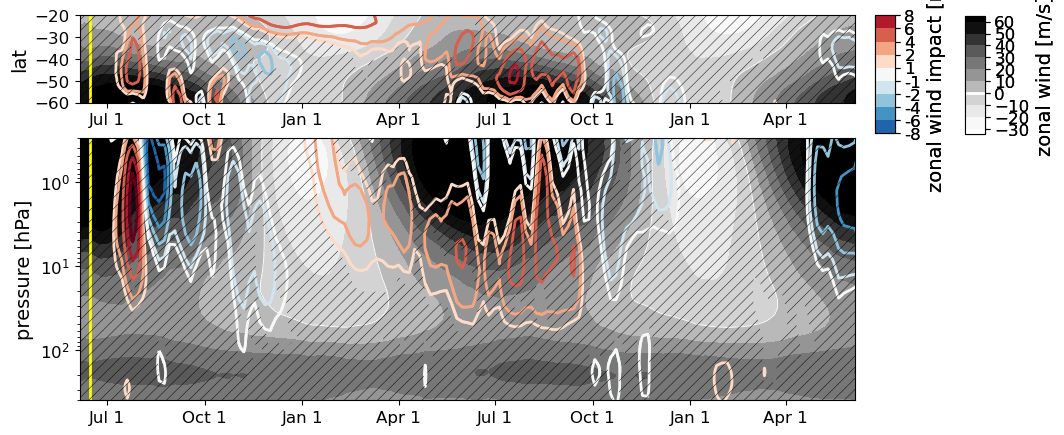

In [131]:
for ii in range(len(latbands)):    
    # ================= NORTH MIDLATS =================
    fig_width = 10
    fig = plt.figure(figsize=(fig_width, fig_width/2))
    gs  = gridspec.GridSpec(2, 1, height_ratios=[1, 3])

    # ========== first plot the pressure level data from lat_time_impact on this lat band
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    # ----- ploting settings
    hatch = '///'
    cmap   = 'Greys'  # data colormap
    zcolor = 'w'      # data zero-line color
    zlw    = 0.66     # data zero-line linewidth
    icmap  = 'RdBu_r' # impact colormap
    ilw    = 2     # impact linewidth
    ils    = '-'     # impact linestyle
    ilwsig = 2        # impact significant linewidth
    lev    = np.arange(-30, 61, 10) # data levels
    ilev   = [-8, -6, -4, -2.3, -1.5, 1.5, 2.3, 4, 6, 8] # impact levels
    #p      = pp[ii]  # pressure level
    inorm = putil.get_cmap_norm(ilev, 'uneven') # colormap normalization
    #pargs = {'plev':p, 'method':'nearest'}

    # --- ensemble data
    cfu  = ax1.contourf(time, lat, up_cf, cmap=cmap, levels=lev, extend='both')
    ax1.contour(time, lat, up_cf, colors=zcolor, linewidths=zlw, levels=[0]) # zero line
    # --- eruption
    ax1.axvline(x=datetime(1991, 6, 15), color='yellow', ls='-', lw=2)
    # --- impact data
    ax1.contour(time, lat, up_impact, cmap=icmap, levels=ilev, norm=inorm, linewidths=ilw, linestyles=ils)
    ax1.contour(time, lat, up_impact_filtered, cmap=icmap, levels=ilev, norm=inorm, linewidths=ilwsig)
    # dummy plot for impact colorbar
    cfui = ax1.contourf(time, lat, up_impact, cmap=icmap, levels=ilev, norm=inorm, alpha=0)
    # --- pval
    ax1.contourf(time, lat, up_pval, levels=[0.05, up_pval.max()], hatches=[hatch], colors='w', alpha=0, zorder=300)

    # ----- make colorbars
    cbar_pos  = [1.01, 0.642, 0.02, 0.236]
    cbari_pos = [0.92, 0.644, 0.02, 0.236]
    # -- data
    cbar = fig.colorbar(cfu, cax=fig.add_axes(cbar_pos), extendrect=True, orientation='vertical', location='right')
    cbar.set_label('zonal wind [m/s]')
    #cbar.set_ticks(lev)
    cbar.ax.axhline(y=0, color='w', lw=2)
    # -- impact
    cbari = fig.colorbar(cfui, cax=fig.add_axes(cbari_pos), orientation='vertical', location='right', format='%d')
    cbari.solids.set_alpha(1)
    cbari.set_label('zonal wind impact [m/s]')
    #cbari.set_ticks(ilev)
    #cbari.set_ticklabels(np.array(ilev).astype(int))

    # ----- format
    putil.season_timeticks(ax1.xaxis, time, 'season')
    ax1.set_ylabel('lat')
    ax1.set_yticks(np.arange(latbands[ii][0]-10, latbands[ii][1]+11, 10))
    ax1.set_ylim([latbands[ii][0]-10, latbands[ii][1]+10])
    ax1.set_xlim(timelim)



    # ========== now plot the band average p-time impact

    # --- ensemble data
    cfu  = ax2.contourf(time, plev, u_cf[ii], cmap=cmap, levels=lev, extend='both')
    ax2.contour(time, plev, u_cf[ii], colors=zcolor, linewidths=zlw, levels=[0]) # zero line
    # --- eruption
    ax2.axvline(x=datetime(1991, 6, 15), color='yellow', ls='-', lw=2)
    # --- impact data
    ax2.contour(time, plev, u_impact[ii], cmap=icmap, levels=ilev, norm=inorm, linewidths=ilw, linestyles=ils)
    # --- pval
    ax2.contour(time, plev, u_impact_filtered[ii], cmap=icmap, levels=ilev, norm=inorm, linewidths=ilwsig)
    # dummy plot for impact colorbar
    mpl.rcParams['hatch.linewidth'] = 0.33
    cfui = ax1.contourf(time, plev, u_impact[ii], cmap=icmap, levels=ilev, norm=inorm, alpha=0)
    ax2.contourf(time, plev, u_pval[ii], levels=[0.05, u_pval[ii].max()], hatches=[hatch], colors='w', alpha=0, zorder=300)

    # ----- make colorbars
    cbar_pos  = [1.01, 0.642, 0.02, 0.236]
    cbari_pos = [0.92, 0.644, 0.02, 0.236]
    # -- data
    cbar = fig.colorbar(cfu, cax=fig.add_axes(cbar_pos), extendrect=True, orientation='vertical', location='right')
    cbar.set_label('zonal wind [m/s]')
    #cbar.set_ticks(lev)
    cbar.ax.axhline(y=0, color='w', lw=2)
    # -- impact
    cbari = fig.colorbar(cfui, cax=fig.add_axes(cbari_pos), orientation='vertical', location='right', format='%d')
    cbari.solids.set_alpha(1)
    cbari.set_label('zonal wind impact [m/s]')
    #cbari.set_ticks(ilev)
    #cbari.set_ticklabels(np.array(ilev).astype(int))

    # ----- format
    putil.season_timeticks(ax2.xaxis, time, 'season')
    ax2.set_ylabel('pressure [hPa]')
    #ax2.set_yticks(np.arange(latbands[0][0]-10, latbands[0][1]+11, 10))
    ax2.set_ylim(plim)
    ax2.invert_yaxis()
    ax2.set_yscale('log')
    ax2.set_xlim(timelim)
                 
plt.show()